# Waste Distribution

In [195]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import math
import re
import os

## Load data

In [196]:
onedrive = os.path.join("/", "mnt", "c", "Users", "eschmann", "OneDrive - epfl.ch", "Research IT", "Advanced Services", "0042 – Blue City", "BlueCityViz")
SP04 = os.path.join(onedrive, "SP04_Waste")
waste_dir = os.path.join(SP04, "Waste collection points by types (density-based spatial clustering)")

sous_secteurs_filename = os.path.join(SP04, "Lausanne Districts.gpkg")
Household_waste_filename = os.path.join(waste_dir, "DI_final_clustered_centroids.csv")
paper_waste_filename = os.path.join(waste_dir, "PC_final_clustered_centroids.csv")
glass_waste_filename = os.path.join(waste_dir, "VE_final_clustered_centroids.csv")
Organic_waste_filename = os.path.join(waste_dir, "DV_final_clustered_centroids.csv")
stats_filename = os.path.join(SP04, "Waste generation per person in each neighborhood.xlsx")

sous_secteurs = gpd.read_file(sous_secteurs_filename)

Household_waste = gpd.read_file(Household_waste_filename)
paper_waste = gpd.read_file(paper_waste_filename)
glass_waste = gpd.read_file(glass_waste_filename)
Organic_waste = gpd.read_file(Organic_waste_filename)
stats = pd.read_excel(stats_filename, sheet_name="CSV")

In [197]:
sous_secteurs["quartier_number"] = sous_secteurs["RefName"].str.extract(r'Quartier (\d+)')[0]
stats_mapping = stats.set_index(stats["Quartier"].str.extract(r'^(\d+)')[0])["Quartier"].to_dict()

sous_secteurs["RefName"] = sous_secteurs["quartier_number"].map(stats_mapping)

sous_secteurs.drop(columns=["quartier_number"], inplace=True)


stats.rename(columns={"household_total": "DI", "paper_total": "PC", "glass_total": "VE", "organic_total": "DV"}, inplace=True)

In [198]:
def create_geometry(df):
    """
    Create a geometry column from the longitude and latitude columns of a DataFrame.
    """
    df["geometry"] = gpd.points_from_xy(df["centroid_lon"], df["centroid_lat"])

    df.drop(columns=["centroid_lon", "centroid_lat"], inplace=True)

    return df


## Create a map of the waste collection points in Lausanne, colored by type of waste.

In [199]:
Household_waste = create_geometry(Household_waste)
paper_waste = create_geometry(paper_waste)
glass_waste = create_geometry(glass_waste)
Organic_waste = create_geometry(Organic_waste)

Household_waste["type"] = "DI"
paper_waste["type"] = "PC"
glass_waste["type"] = "VE"
Organic_waste["type"] = "DV"

total_waste = pd.concat([Household_waste, paper_waste, glass_waste, Organic_waste], ignore_index=True)

total_waste = gpd.GeoDataFrame(total_waste, geometry="geometry", crs="EPSG:4326")
total_waste.to_crs(sous_secteurs.crs, inplace=True)

## Join the waste collection points with the sous-secteurs.

In [200]:
total_waste["quartier"] = total_waste.sjoin(sous_secteurs[["RefName", "geometry"]], how="left", predicate="within")["RefName"]
total_waste.dropna(subset="quartier", inplace=True)


In [201]:
waste_types = total_waste["type"].unique()
Quartiers = total_waste["quartier"].unique()

for wt in waste_types:
    for q in Quartiers:
        count = total_waste[(total_waste["type"] == wt) & (total_waste["quartier"] == q)].shape[0]
        total_waste.loc[(total_waste["type"] == wt) & (total_waste["quartier"] == q), "amount"] = stats.loc[(stats["Quartier"] == q)][wt].values[0] / count

total_waste["amount_month"] = total_waste["amount"] / 12
total_waste["amount_week"] = total_waste["amount"] / 52
total_waste["amount_day"] = total_waste["amount"] / 365

In [202]:
type(total_waste["amount_day"].iloc[0])

numpy.float64

## Group the waste collection points by cluster of max 100kg of waste per day

In [203]:
def regroup_cluster(waste, map_centroid, max_amount_per_cluster=500):
    """
    regroup cluster based on their position, type of waste and the amount of waste collected per week
    """
    waste["cluster"] = None
    waste["angle"] = waste.geometry.apply(lambda x: math.atan2(x.y - map_centroid.y, x.x - map_centroid.x))
    waste = waste.sort_values(["type", "angle"]).reset_index(drop=True)
    
    current_weight = 0
    current_cluster = 0
    current_type = waste["type"].iloc[0]

    for idx, cw in waste.iterrows():
        
        if current_weight + cw["amount_week"] > max_amount_per_cluster or cw["type"] != current_type:
            current_cluster += 1
            current_weight = 0
            current_type = cw["type"]
        
        current_weight += cw["amount_week"]
        waste.loc[idx, "cluster"] = current_cluster
    
    waste.drop(columns=["angle"], inplace=True)

    return waste

In [204]:
map_centroid = sous_secteurs.unary_union.centroid

total_waste = regroup_cluster(total_waste, map_centroid)

/tmp/ipykernel_7267/1231041395.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map_centroid = sous_secteurs.unary_union.centroid


## Plot the clusters on the map, colored by cluster and sized by the amount of waste collected per month.

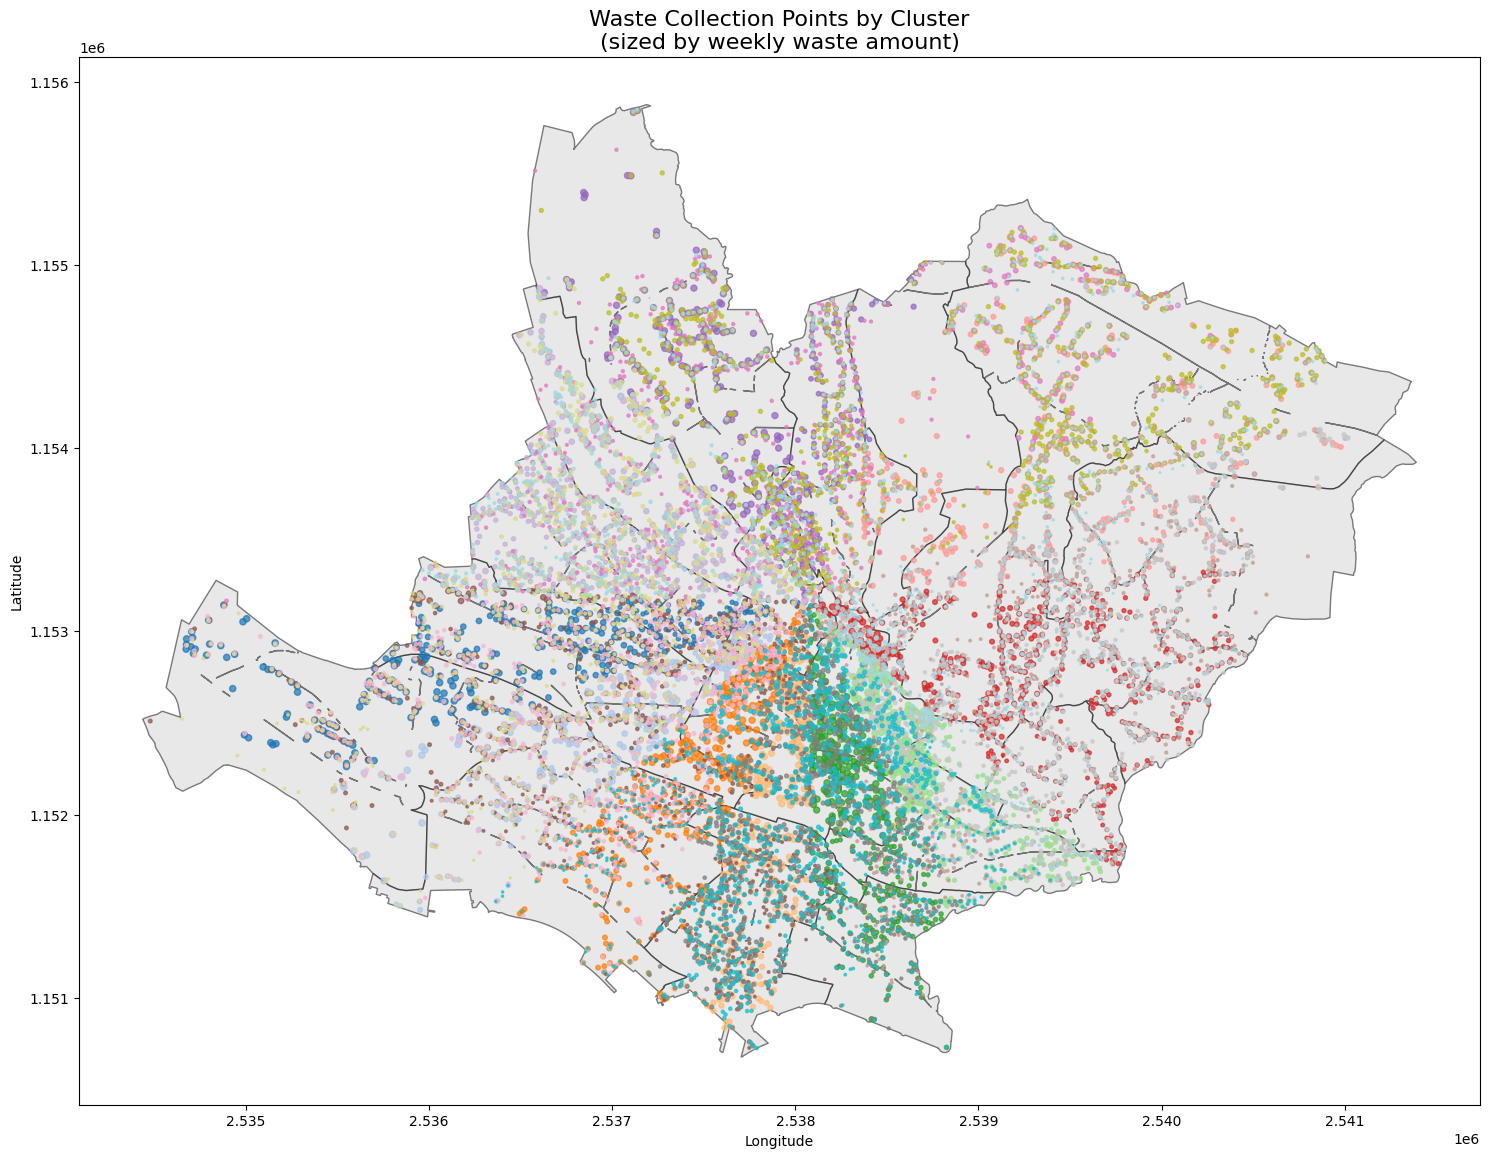

In [205]:
fig, ax = plt.subplots(figsize=(15, 12))


sous_secteurs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

total_waste.plot(
    ax=ax,
    column='cluster',
    markersize=total_waste['amount'] / 100,  
    cmap='tab20',
    legend=False,
    alpha=0.7,
    categorical=True
)

# Add title and labels
ax.set_title('Waste Collection Points by Cluster\n(sized by weekly waste amount)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()